In [1]:
import numpy as np
import glob
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import pyproj as proj
from scipy.stats import norm

def folder2cube(files, size_raster):
    base_set = glob.glob(files)
    cube = np.zeros(size_raster + (len(base_set),))
    for i, model in enumerate(base_set): 
        cube[:,:,i] = np.loadtxt(model, skiprows = 1).reshape(size_raster)
    return cube, len(base_set)

def my_fault(file):
    fault = np.loadtxt(file, skiprows = 1).reshape(size_raster)
    fault[fault < -9900.] = 'nan'
    return fault

def show_it(data, turn = True):
    if turn:
        plt.imshow(data.T, origin="upper")
    else:
        plt.imshow(data, origin="upper")
    plt.colorbar()
    plt.show()
    
size_raster = (250,162)

In [2]:
base_cube, base_n = folder2cube('data/Hackaton/BaseSet/MapSimu__*.data',size_raster)
top_cube, top_n = folder2cube('data/Hackaton/TopSet/MapSimu__*.data',size_raster)

In [3]:
volume_file = 'data/Hackaton/VolumeDistribution/Volumes'

vol = pd.read_csv(volume_file, delim_whitespace=True)

In [4]:
ds = xr.Dataset()  

X_corner = 390885
Y_corner = 7156947
dx, dy = 25, 25

#top_model = np.min([np.min(base_cube),np.min(top_cube)])
#bottom_model = np.max([np.max(base_cube),np.max(top_cube)])

top_model = 950
bottom_model = 1050
dz = 100

xx = np.linspace(X_corner, X_corner+size_raster[0]*dx, size_raster[0])
yy = np.linspace(Y_corner, Y_corner+size_raster[1]*dy, size_raster[1])
zz = np.linspace(top_model, bottom_model, dz)
rr = np.array(range(0,np.shape(base_cube)[2]))

model = np.linspace(0, top_model, base_n)

ds.coords['X'] = xx
ds.coords['Y'] = yy
ds.coords['Z'] = zz
ds.coords['MODEL'] = model

ds['BASE'] = (('X', 'Y', 'MODEL'), base_cube)
ds['TOP'] = (('X', 'Y', 'MODEL'), top_cube)

In [164]:
base_mean = ds['BASE'].mean(dim='MODEL')
base_std = ds['BASE'].std(dim='MODEL')

top_mean = ds['TOP'].mean(dim='MODEL')
top_std = ds['TOP'].std(dim='MODEL')

#mid_volumes = top_cube - base_cube
#show_it(mid_volumes.mean(axis=2))
#show_it(mid_volumes.std(axis=2))

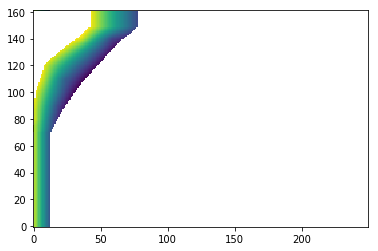

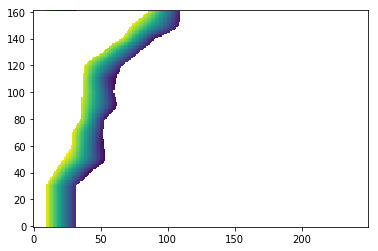

In [170]:
fault_max = my_fault('data/Hackaton/Fault_Max/Isochron.data')
fault_min = my_fault('data/Hackaton/Fault_Min/Isochron.data')

last_line_min = fault_min[:,30]
last_line_max = fault_max[:,70]

for y in range(0,len(yy)): 
    if np.isnan(fault_min[:,y]).all():
        fault_min[:,y] = last_line_min
    if np.isnan(fault_max[:,y]).all():
        fault_max[:,y] = last_line_max

#UGLY CHEAT:
for y in range(150,161):
    fault_max[:,y] = fault_max[:,149]
      
plt.imshow(fault_max.T, origin='lower')
plt.show()

plt.imshow(fault_min.T, origin='lower')
plt.show()

In [79]:
print(np.nanmin(fault_min), np.nanmax(fault_min))
print(np.nanmin(fault_max), np.nanmax(fault_max))

639.607177734375 1194.9718017578125
513.8126220703125 1191.294189453125


In [127]:
fault_frame = np.zeros(size_raster)

for x in range(0,len(xx)): 
    for y in range(0,len(yy)): 
        if (np.isfinite(fault_max[x,y]) or np.isfinite(fault_min[x,y])):
            fault_frame[:x,y] = 1

cube_max = np.zeros(size_raster + (dz,))
cube_min = np.zeros(size_raster + (dz,))
            
for x in range(0,len(xx)): 
    for y in range(0,len(yy)):
        if fault_frame[x,y] == 1:
            for z in range(1,len(zz)-1):
                if abs(fault_max[x,y] - zz[z]) < 22:
                    cube_max[:x,y,z] = 1
                if abs(fault_min[x,y] - zz[z]) < 22:
                    cube_min[:x,y,z] = 1          

In [128]:
fault_dist = np.zeros(size_raster + (dz,))

for y in range(0,len(yy)):
        for z in range(1,len(zz)-1):  
            min_here = len(xx)-np.argmax(cube_min[:,y,z][::-1]==1)
            max_here = len(xx)-np.argmax(cube_max[:,y,z][::-1]==1)
            fill_here = min_here - max_here
            fault_dist[max_here:min_here,y,z] = np.linspace(1., 0., num=fill_here)
            fault_dist[:max_here,y,z] = 1
            
fault_dist = 1 - fault_dist 

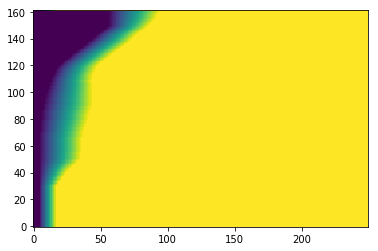

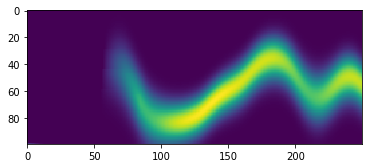

In [129]:
plt.imshow(fault_dist[:,:,40].T, origin='lower')
plt.show()

plt.imshow(mid_fault[:,150,:].T)
plt.show()

In [130]:
top_cloud = np.zeros(size_raster + (dz,))
base_cloud = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        top_cloud[x,y,:] = norm.pdf(zz,top_mean.values[x,y],top_std.values[x,y])

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        base_cloud[x,y,:] = norm.pdf(zz,base_mean.values[x,y],base_std.values[x,y])


/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [131]:
top_unit = np.zeros(size_raster + (dz,))
base_unit = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        top_unit[x,y,:] = 1 - norm.cdf(zz,top_mean.values[x,y],top_std.values[x,y])

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        base_unit[x,y,:] = norm.cdf(zz,base_mean.values[x,y],base_std.values[x,y])
        
mid_unit = 1 - top_unit - base_unit

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


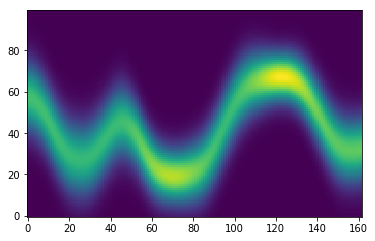

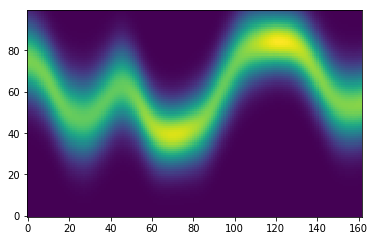

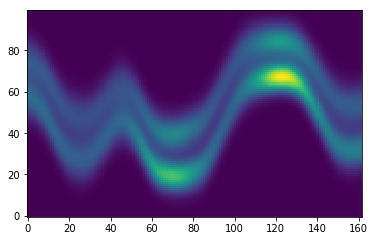

In [154]:
plt.imshow(top_cloud[50,:,:].T,origin='lower')
plt.show()

plt.imshow(base_cloud[50,:,:].T,origin='lower')
plt.show()

plt.imshow(0.5*(base_cloud[50,:,:]**3+top_cloud[50,:,:]**3).T,origin='lower')
plt.show()

In [15]:
r_horizons = np.zeros(size_raster + (dz,) + (len(rr),), dtype=np.uint8)

r_horizons[:] = np.nan

stop_here = 2

for r in rr[:stop_here]:
    for x in range(0,len(xx)): 
        for y in range(0,len(yy)):
            for z in range(0+1,len(zz)-1):
                if zz[z-1] < base_cube[x,y,r] < zz[z+1]:
                    r_horizons[x,y,z,r] = 1
                if zz[z-1] < top_cube[x,y,r] < zz[z+1]:
                    r_horizons[x,y,z,r] = 1
    print('%s '%r, end='')

#np.save('realisation_all.npy', r_horizons)  

0 1 

(250, 162, 100, 200)


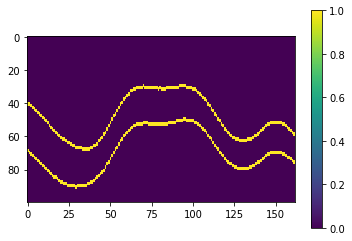

In [17]:
print(np.shape(r_horizons))
show_it(r_horizons[150,:,:,1])

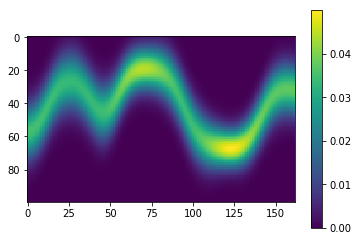

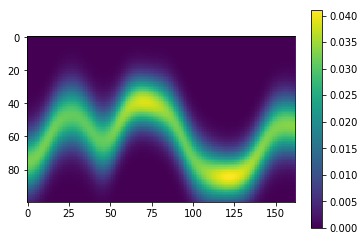

In [18]:
show_it(top_cloud[50,:,:])
show_it(base_cloud[50,:,:])

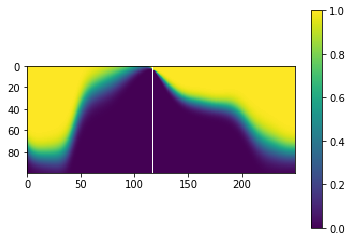

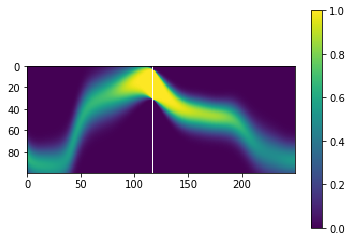

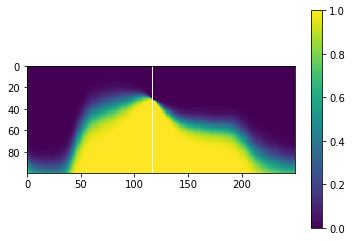

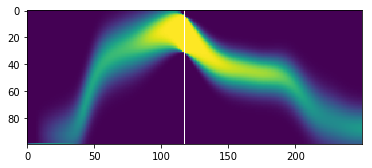

In [134]:
#170, 93

show_it(top_unit[:,93,:])
show_it(mid_unit[:,93,:])
show_it(base_unit[:,93,:])

#all_unit = top_unit + mid_unit + base_unit
#show_it(all_unit[:,93,:])

plt.imshow(mid_fault[:,93,:].T)
plt.show()

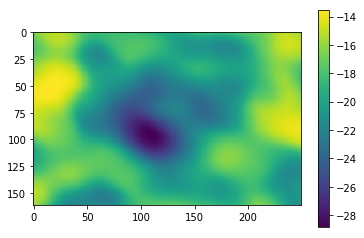

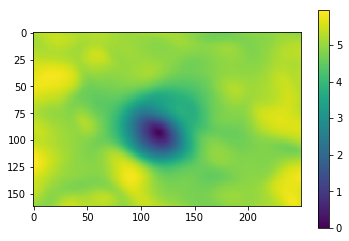

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


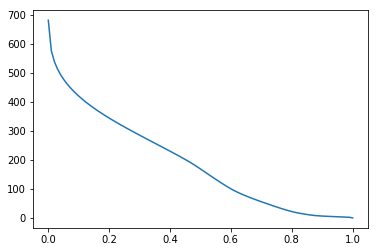

In [176]:
P_gates = np.linspace(0.001, 1, 100)
geo_volumes = []

for P_gate in P_gates:
    unit_poly = np.where(mid_unit>P_gate, mid_unit, 0).astype('bool')
    geo_volumes.append(unit_poly.sum()*25*25*4.04/10e6)
    
plt.plot( P_gates,geo_volumes)
plt.show()

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


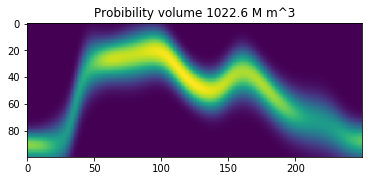

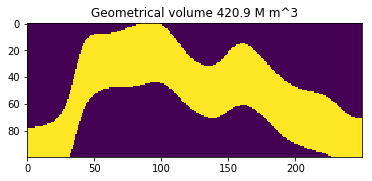

In [171]:
P_gate = 0.1

unit_poly = np.where(mid_unit>P_gate, mid_unit, 0).astype('bool')
geo_volume = unit_poly.sum()*25*25*4.04/10e6
p_volume = np.isfinite(mid_unit).sum()*25*25*4.04/10e6

plt.imshow(mid_unit[:,72].T, origin="upper")
plt.title('Probibility volume %0.1f M m^3' %p_volume)
plt.show()

plt.imshow(unit_poly[:,72].T, origin="upper")
plt.title('Geometrical volume %0.1f M m^3' %geo_volume)
plt.show()

In [112]:
mid_fault = np.multiply(fault_dist, mid_unit)

In [113]:
#np.save('top_cloud.npy', top_cloud) 
#np.save('base_cloud.npy', base_cloud) 
#np.save('top_unit.npy', top_unit) 
#np.save('mid_unit.npy', mid_unit) 
#np.save('base_unit.npy', base_unit) 
np.save('fault_dist.npy', fault_dist) 
np.save('mid_fault.npy', mid_fault) 